## Загрузка данных

In [6]:
import pandas as pd 
import numpy as np

fold = pd.read_csv("./Data/fold.csv")
unfold = pd.read_csv("./Data/unfold.csv")

profile = pd.read_csv("./Data/profile.csv")

delayexp = pd.read_csv("./Data/delayexp.csv")

delay_fig4 = pd.read_csv("./Data/delay_fig4.csv")
plotmat_fig4 = pd.read_csv("./Data/plotmat_fig4.csv")
plotmat2_fig4 = pd.read_csv("./Data/plotmat2_fig4.csv")

delay_fig5 = pd.read_csv("./Data/delay_fig5.csv")
plotmat_fig5 = pd.read_csv("./Data/plotmat_fig5.csv")
plotmat2_fig5 = pd.read_csv("./Data/plotmat2_fig5.csv")

Здесь рассчитываем, как меняется сигнал (профиль возмущения) в модели действия потенциалов нейрона. Для упрощения расчетов, форму действия потенциала приблизительно описывают с помощью нескольких парабол(кусочно-квадратичная функция).

In [8]:
vel = 3.1  # скорость распространения импульса

x = np.arange(-0.2 * vel, 1.2 * vel + 1e-3, 1e-3)
xb = np.arange(-3, 19 + 1e-3, 1e-3)

Vmax = 110  #максимальное значение амплитуды импульса
SL = 4  #длительность потенциала

# a это переменная управляющая деполяризационным откликом
t0 = 0
t1 = lambda a1: np.sqrt(Vmax / (2 * a1))
t2 = lambda a1: 2 * t1(a1) + Vmax / (a1 * (SL - 2 * t1(a1)))
t3 = SL

a2 = lambda a1: Vmax / ((2 * t1(a1) - SL) * (t2(a1) - SL))

x0 = t0 * vel
x1 = lambda a1: t1(a1) * vel
x2 = lambda a1: t2(a1) * vel
x3 = t3 * vel

# Вычисление V 
Vquad = lambda x, a1: (a1 * (x - x0)**2 * (x > x0) * (x <= x1(a1)) / vel**2 +
                       (Vmax - a1 * (x - 2 * x1(a1))**2 / vel**2) * (x > x1(a1)) * (x <= x2(a1)) +
                       a2(a1) * (x - x3)**2 * (x > x2(a1)) * (x <= x3) / vel**2)
# Вторая производная V
Vquadpp = lambda x, a1: (2 * a1 * (x > x0) * (x <= x1(a1)) -
                         2 * a1 * (x > x1(a1)) * (x <= x2(a1)) +
                         2 * a2(a1) * (x > x2(a1)) * (x <= x3)) / vel**2

# Cable parameters:
lambm = 1.3794
lambn = 0.055
taum = 0.47
taun = 0.03
deltaL = 0.01

# Homogenized parameters
lambhom = ((1 - deltaL) * (1 / lambm**2) + deltaL * (1 / lambn**2))**(-1/2) #постоянная длины для всего аксона (7)
tauhom = lambhom**2 * ((1 - deltaL) * (taum / lambm**2) + deltaL * (taun / lambn**2)); #времени длины для всего аксона (8)
c = vel;

# Length constants defining convolution kernel:
lamb1 = 0.5 * np.sqrt(c**2 * tauhom**2 + 4 * lambhom**2) + 0.5 * c * tauhom #(22) скорость экспоненциального затухания влияния справа от источника сигнала.
lamb2 = 0.5 * np.sqrt(c**2 * tauhom**2 + 4 * lambhom**2) - 0.5 * c * tauhom #(22) скорость экспоненциального роста влияния слева от источника сигнала.
lamb3 = lambhom**2 / np.sqrt(4 * lambhom**2 + c**2 * tauhom**2) #(21) ядро свертки (convolution kernel), определяющее, как быстро затухает влияние потенциала в точке y на потенциал в точке x


#вспомогательная функция (... - перенапавление на след. строку). Явно не описана в статье
FF = lambda x, x1, x2: (lamb1 * (np.exp((x - x1) / lamb1) - np.exp((x - x2) / lamb1)) * (x <= x1) +
                       (lamb1 * (1 - np.exp((x - x2) / lamb1)) + lamb2 * (1 - np.exp(-(x - x1) / lamb2))) * (x > x1) * (x < x2) +
                       lamb2 * (np.exp(-(x - x2) / lamb2) - np.exp(-(x - x1) / lamb2)) * (x >= x2))

#функция , описывающая пространственный профиль возмущения (31)        
GG = lambda x, a1: -(a1 / c**2) * FF(x, 0, c * t1(a1)) + \
                   (a1 / c**2) * FF(x, c * t1(a1), c * t2(a1)) - \
                   (a2(a1) / c**2) * FF(x, c * t2(a1), c * t3)

# parameters defining the strength of coupling:
sigrat = 1/ 3#внеклеточная проводимость/ксональная проводимость
rho = 0.3 #плотность аксонов
g = 0.6 #общая проводимость 
pre = (1/2)/(1+sigrat*((1-rho)/(g**2*rho))) #(5) градиент потенциала в пространстве (вторая производная потеницала) (1/2) - доля вклада аксона в взаимодействие

#градиент потенциала в пространстве зависящий от GG
pert2 = lambda x, a1: pre * lamb3 * GG(x, a1)


## Графики

Figure 2a: Параметр a1 определяет форму профиля острия, где большие значения соответствуют более быстрой деполяризации:

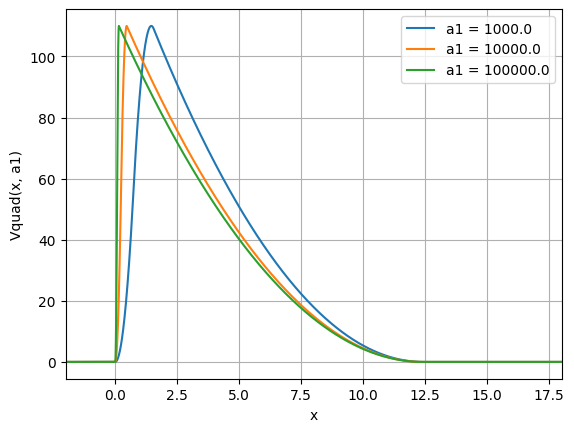

In [9]:
import matplotlib.pyplot as plt

a1_values = [1e3, 1e4, 1e5]
for a1 in a1_values:
    plt.plot(xb, Vquad(xb, a1), label=f'a1 = {a1}')

plt.xlim([-2, 18])
plt.xlabel('x')
plt.ylabel('Vquad(x, a1)')
plt.legend()
plt.grid(True)
plt.show()

Figure 2b: Кривизна (вторая пространственнаяпроизводная) кусочно-постоянна. Для удобства сравнения она показана в логарифмической шкале со знаком. Единица измерения кривизны - мВ/мм2.: 

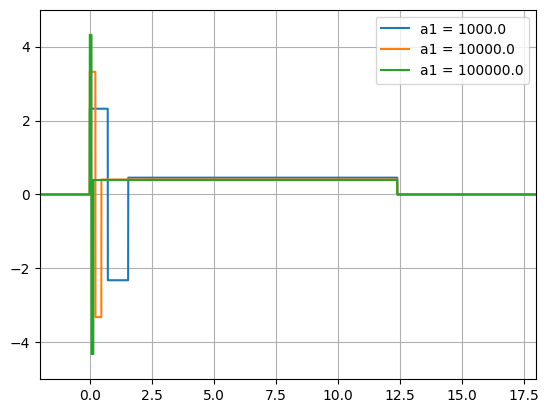

In [10]:
for a1 in a1_values:
    y_values = np.sign(Vquadpp(xb, a1)) * np.log10(np.abs(Vquadpp(xb, a1)) + 1)
    plt.plot(xb, y_values, label=f'a1 = {a1}')

plt.xlim([-2, 18])
plt.ylim([-5, 5])
plt.legend()
plt.grid(True)
plt.show()

Figure 2c:Результирующее возмущение в пассивном аксоне:

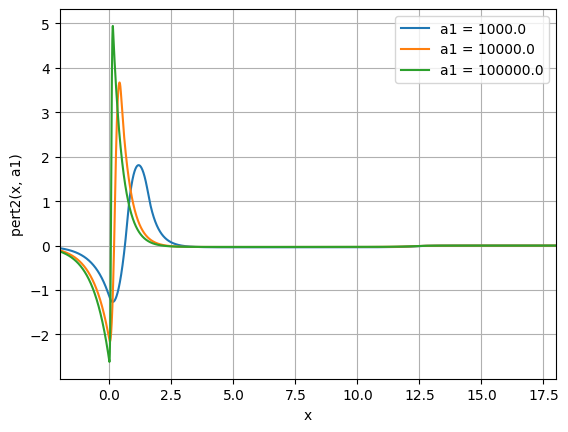

In [11]:
for a1 in a1_values:
    plt.plot(xb, pert2(xb, a1), label=f'a1 = {a1}')

plt.xlim([-2, 18])
plt.xlabel('x')
plt.ylabel('pert2(x, a1)')
plt.legend()
plt.grid(True)
plt.show()

Функция модели:

In [13]:
def fQuad_approx(d):
    vel = 3.1  # скорость распространения импульса

    x = np.arange(-0.2 * vel, 1.2 * vel + 1e-3, 1e-3)
    xb = np.arange(-3, 19 + 1e-3, 1e-3)

    Vmax = 110  #максимальное значение амплитуды импульса
    SL = 4  #длительность потенциала

    # a это переменная управляющая деполяризационным откликом
    t0 = 0
    t1 = lambda a1: np.sqrt(Vmax / (2 * a1))
    t2 = lambda a1: 2 * t1(a1) + Vmax / (a1 * (SL - 2 * t1(a1)))
    t3 = SL

    a2 = lambda a1: Vmax / ((2 * t1(a1) - SL) * (t2(a1) - SL))

    x0 = t0 * vel
    x1 = lambda a1: t1(a1) * vel
    x2 = lambda a1: t2(a1) * vel
    x3 = t3 * vel

    # Вычисление V 
    Vquad = lambda x, a1: (a1 * (x - x0)**2 * (x > x0) * (x <= x1(a1)) / vel**2 +
                           (Vmax - a1 * (x - 2 * x1(a1))**2 / vel**2) * (x > x1(a1)) * (x <= x2(a1)) +
                           a2(a1) * (x - x3)**2 * (x > x2(a1)) * (x <= x3) / vel**2)
    # Вторая производная V
    Vquadpp = lambda x, a1: (2 * a1 * (x > x0) * (x <= x1(a1)) -
                             2 * a1 * (x > x1(a1)) * (x <= x2(a1)) +
                             2 * a2(a1) * (x > x2(a1)) * (x <= x3)) / vel**2

    # Cable parameters:
    lambm = 1.3794*d
    lambn = 0.055*(d)**0.5
    taum = 0.47
    taun = 0.03
    deltaL = 0.01

    # Homogenized parameters
    lambhom = ((1 - deltaL) * (1 / lambm**2) + deltaL * (1 / lambn**2))**(-1/2) #постоянная длины для всего аксона (7)
    tauhom = lambhom**2 * ((1 - deltaL) * (taum / lambm**2) + deltaL * (taun / lambn**2)); #времени длины для всего аксона (8)
    c = vel;

    # Length constants defining convolution kernel:
    lamb1 = 0.5 * np.sqrt(c**2 * tauhom**2 + 4 * lambhom**2) + 0.5 * c * tauhom #(22) скорость экспоненциального затухания влияния справа от источника сигнала.
    lamb2 = 0.5 * np.sqrt(c**2 * tauhom**2 + 4 * lambhom**2) - 0.5 * c * tauhom #(22) скорость экспоненциального роста влияния слева от источника сигнала.
    lamb3 = lambhom**2 / np.sqrt(4 * lambhom**2 + c**2 * tauhom**2) #(21) ядро свертки (convolution kernel), определяющее, как быстро затухает влияние потенциала в точке y на потенциал в точке x


    #вспомогательная функция (... - перенапавление на след. строку). Явно не описана в статье
    FF = lambda x, x1, x2: (lamb1 * (np.exp((x - x1) / lamb1) - np.exp((x - x2) / lamb1)) * (x <= x1) +
                           (lamb1 * (1 - np.exp((x - x2) / lamb1)) + lamb2 * (1 - np.exp(-(x - x1) / lamb2))) * (x > x1) * (x < x2) +
                           lamb2 * (np.exp(-(x - x2) / lamb2) - np.exp(-(x - x1) / lamb2)) * (x >= x2))

    #функция , описывающая пространственный профиль возмущения (31)        
    GG = lambda x, a1: -(a1 / c**2) * FF(x, 0, c * t1(a1)) + \
                       (a1 / c**2) * FF(x, c * t1(a1), c * t2(a1)) - \
                       (a2(a1) / c**2) * FF(x, c * t2(a1), c * t3)

    # parameters defining the strength of coupling:
    sigrat = 1 / 3#внеклеточная проводимость/ксональная проводимость
    rho = 0.3 #плотность аксонов
    g = 0.6 #общая проводимость 
    pre = (1/2)/(1+sigrat*((1-rho)/(g**2*rho))) #(5) градиент потенциала в пространстве (вторая производная потеницала) (1/2) - доля вклада аксона в взаимодействие

    #градиент потенциала в пространстве зависящий от GG
    pert2 = lambda x, a1: pre * lamb3 * GG(x, a1)

    return np.min(pert2(xb, 740))

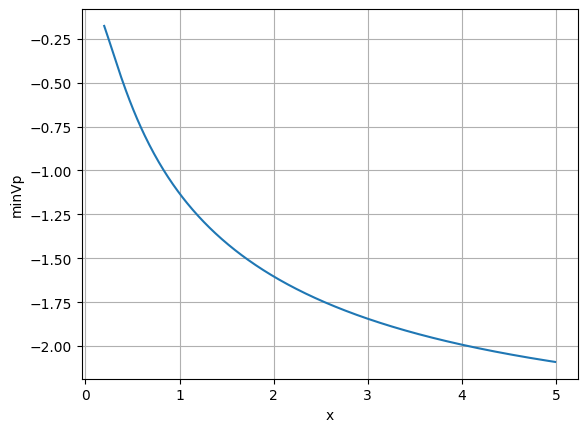

In [19]:
x = np.arange(0.2, 5, 0.01)
y = np.array([fQuad_approx(val) for val in x])

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('minVp')
plt.grid(True)
plt.show()